In [11]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.utils import multi_runs

import abc
from bokeh.palettes import Category20_9 as cols
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import future.utils
import six

Here, we override the DiffusionTrend function from Ndlib to customize the plot.

In [ ]:
if os.environ.get("DISPLAY", "") == "":
    print("no display found. Using non-interactive Agg backend")
    mpl.use("Agg")


__author__ = "Giulio Rossetti"
__license__ = "BSD-2-Clause"
__email__ = "giulio.rossetti@gmail.com"


@six.add_metaclass(abc.ABCMeta)
class DiffusionPlot(object):
    def __init__(self, model, trends):
        self.model = model
        self.trends = trends
        statuses = model.available_statuses
        self.srev = {v: k for k, v in future.utils.iteritems(statuses)}
        self.ylabel = ""
        self.title = ""
        self.nnodes = model.graph.number_of_nodes()
        self.normalized = True

    @abc.abstractmethod
    def iteration_series(self, percentile):
        """
        Prepare the data to be visualized

        :param percentile: The percentile for the trend variance area
        :return: a dictionary where iteration ids are keys and the associated values are the computed measures
        """
        pass

    def plot(self, filename=None, percentile=90, statuses=None, descr=None):
        """
        Generates the plot

        :param filename: Output filename
        :param percentile: The percentile for the trend variance area
        :param statuses: List of statuses to plot. If not specified all statuses trends will be shown.
        """

        pres = self.iteration_series(percentile)

        plt.figure(figsize=(20, 15))

        mx = 0
        i = 0
        for k, l in future.utils.iteritems(pres):

            if statuses is not None and self.srev[k] not in statuses:
                continue
            mx = len(l[0])
            if self.normalized:
                plt.plot(
                    range(0, mx),
                    l[1] / self.nnodes,
                    lw=2,
                    label=self.srev[k],
                    alpha=0.5,
                )  # , color=cols[i])
                plt.fill_between(
                    range(0, mx), l[0] / self.nnodes, l[2] / self.nnodes, alpha=0.2
                )
                # ,color=cols[i])
            else:
                plt.plot(
                    range(0, mx), l[1], lw=2, label=self.srev[k], alpha=0.5
                )  # , color=cols[i])
                plt.fill_between(range(0, mx), l[0], l[2], alpha=0.2)  # ,color=cols[i])

            i += 1

        plt.grid(axis="y")
        plt.xlabel("Iterations", fontsize=40)
        plt.ylabel(self.ylabel, fontsize=40)
        plt.tick_params(axis='both', which='major', labelsize=36)
        plt.legend(loc="best", fontsize=36)
        plt.title(f"fraction infected: {descr[0]}, beta: {descr[1]}, gamma: {descr[2]}", fontsize=38) 
        plt.xlim((0, mx))

        plt.tight_layout()
        if filename is not None:
            plt.savefig(filename)
            plt.clf()
        else:
            plt.show()

class DiffusionTrend(DiffusionPlot):
    def __init__(self, model, trends):
        """
        :param model: The model object
        :param trends: The computed simulation trends
        """
        super(self.__class__, self).__init__(model, trends)
        self.ylabel = "#Nodes"
        self.title = "Diffusion Trend"

    def iteration_series(self, percentile):

        series = {k: [] for k in self.srev.keys()}

        presences = {k: [] for k in self.srev.keys()}
        for t in self.trends:

            for st in t:
                for k in t[st]["node_count"]:
                    presences[k].append(np.array(t[st]["node_count"][k]))

        for st in presences:
            tp = np.percentile(np.array(presences[st]), percentile, axis=0)
            bp = np.percentile(np.array(presences[st]), 100 - percentile, axis=0)
            av = np.average(np.array(presences[st]), axis=0)
            series[st] = (tp, av, bp)

        return series

Functions to implement SIR disease spread on the network

In [ ]:
class Graph:
    def __init__(self, num_of_nodes):
        self.num_of_nodes = num_of_nodes

    def barabasi_albert(self, num_of_edges):
        return nx.barabasi_albert_graph(self.num_of_nodes, num_of_edges)

    def watts_strogatz(self, k_nearest_neighbors, rewiring_probability):
        return nx.watts_strogatz_graph(self.num_of_nodes, k_nearest_neighbors, rewiring_probability)

    def erdos_renyi(self, edge_creation_probability):
        return nx.erdos_renyi_graph(self.num_of_nodes, edge_creation_probability)

In [ ]:
def set_config(beta, gamma, fraction_infected):
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", fraction_infected)
    return config

def run_simulation(beta, gamma, fraction_infected, graph, network_abbrv):        
    config = set_config(beta, gamma, fraction_infected)
    sir_model = ep.SIRModel(graph)
    sir_model.set_initial_status(config)
    trends = multi_runs(sir_model, execution_number=10, iteration_number=100, infection_sets=None, nprocesses=4)
    viz = DiffusionTrend(sir_model, trends)
    viz.plot(filename=f"../assets/{network_abbrv}_trend_beta{beta}_gamma{gamma}_infected{fraction_infected}.png", descr=[fraction_infected, beta, gamma])

In [ ]:
# Set network model params
N = 1000
graph = Graph(num_of_nodes=N)
ba_graph = graph.barabasi_albert(num_of_edges=5)
ws_graph = graph.watts_strogatz(k_nearest_neighbors=6, rewiring_probability=0.1)
er_graph = graph.erdos_renyi(edge_creation_probability=0.1)

# Set disease params
infection_rate = 0.3
recovery_rate = 0.1
fraction = 0.01

Run multiple simulations across different network models

In [ ]:
run_simulation(infection_rate, recovery_rate, fraction, ba_graph, 'BA')
run_simulation(infection_rate, recovery_rate, fraction, ws_graph, 'WS')
run_simulation(infection_rate, recovery_rate, fraction, er_graph, 'ER')

Now, we want to see how varying the number of nodes affect the average shortest path length across network types.

In [ ]:
def compute_average_shortest_path_length(N):
    graph = Graph(num_of_nodes=N)
    
    ba_graph = graph.barabasi_albert(num_of_edges=5)
    ws_graph = graph.watts_strogatz(k_nearest_neighbors=6, rewiring_probability=0.1)
    er_graph = graph.erdos_renyi(edge_creation_probability=0.1)
    
    ba_avg_len = nx.average_shortest_path_length(ba_graph)
    ws_avg_len = nx.average_shortest_path_length(ws_graph)
    er_avg_len = nx.average_shortest_path_length(er_graph)
    
    return ba_avg_len, ws_avg_len, er_avg_len

N_values = [100, 1000, 10000]

ba_results = []
ws_results = []
er_results = []

for N in N_values:
    ba_len, ws_len, er_len = compute_average_shortest_path_length(N)
    ba_results.append(ba_len)
    ws_results.append(ws_len)
    er_results.append(er_len)


plt.figure(figsize=(10,6))
plt.loglog(N_values, ba_results, 'o-', label='Barabási-Albert')
plt.loglog(N_values, ws_results, 'o-', label='Watts-Strogatz')
plt.loglog(N_values, er_results, 'o-', label='Erdős–Rényi')

print('This is BA:', ba_results)
print('This is WS:', ws_results)
print('This is ER:', er_results)

bar_width = 0.25
r1 = np.arange(len(N_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(10,6))

plt.bar(r1, ba_results, color='#122640', width=bar_width, edgecolor='grey', label='Barabasi-Albert', log=True)
plt.bar(r2, ws_results, color='#558F8B', width=bar_width, edgecolor='grey', label='Watts-Strogatz', log=True)
plt.bar(r3, er_results, color='#B8D5B2', width=bar_width, edgecolor='grey', label='Erdos-Renyi', log=True)

plt.xlabel('Number of nodes', fontweight='bold', fontsize=15)
plt.xticks([r + bar_width for r in range(len(ba_results))], ['100', '1000', '10000'])
plt.ylabel('Average shortest path length', fontweight='bold', fontsize=15)
plt.yticks([2, 3, 4, 5, 6, 7, 8, 9], ['2', '3', '4', '5', '6', '7', '8', '9'])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Average shortest path length vs. Number of nodes', fontsize=20)
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.tight_layout()
plt.savefig('../assets/stats_avg_shortest_path_length.png')

We will vary the parameter setting for each network model while keeping the number of nodes constant to 1000. To do this, we need to create the instances of Graph class.

In [12]:
N = 1000
graph = Graph(num_of_nodes=N)
ba_num_of_edges = range(2, 11) 
ws_k_nearest_neighbors = range(4, 10)
ws_rewiring_probabilities = [0.01, 0.1, 0.5, 1.0] 
er_creation_probabilities = [0.01, 0.05, 0.1, 0.5]

In [ ]:
ba_degrees = []
ws_degrees = []
er_degrees = []

for edge in ba_num_of_edges:
    ba_graph = graph.barabasi_albert(num_of_edges=edge)
    ba_degrees.extend(list(nx.degree_centrality(ba_graph).values()))

for k in ws_k_nearest_neighbors:
    for p in ws_rewiring_probabilities :
        ws_graph = graph.watts_strogatz(k_nearest_neighbors=k, rewiring_probability=p)
        ws_degrees.extend(list(nx.degree_centrality(ws_graph).values()))

for p in er_creation_probabilities:
    er_graph = graph.erdos_renyi(edge_creation_probability=p)
    er_degrees.extend(list(nx.degree_centrality(er_graph).values()))

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

axes[0].hist(ba_degrees, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Barabási-Albert Degree Centrality Distribution')
axes[0].set_xlabel('Degree Centrality')
axes[0].set_ylabel('Frequency')

axes[1].hist(ws_degrees, bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Watts-Strogatz Degree Centrality Distribution')
axes[1].set_xlabel('Degree Centrality')
axes[1].set_ylabel('Frequency')

axes[2].hist(er_degrees, bins=30, color='lightgreen', edgecolor='black')
axes[2].set_title('Erdős–Rényi Degree Centrality Distribution')
axes[2].set_xlabel('Degree Centrality')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

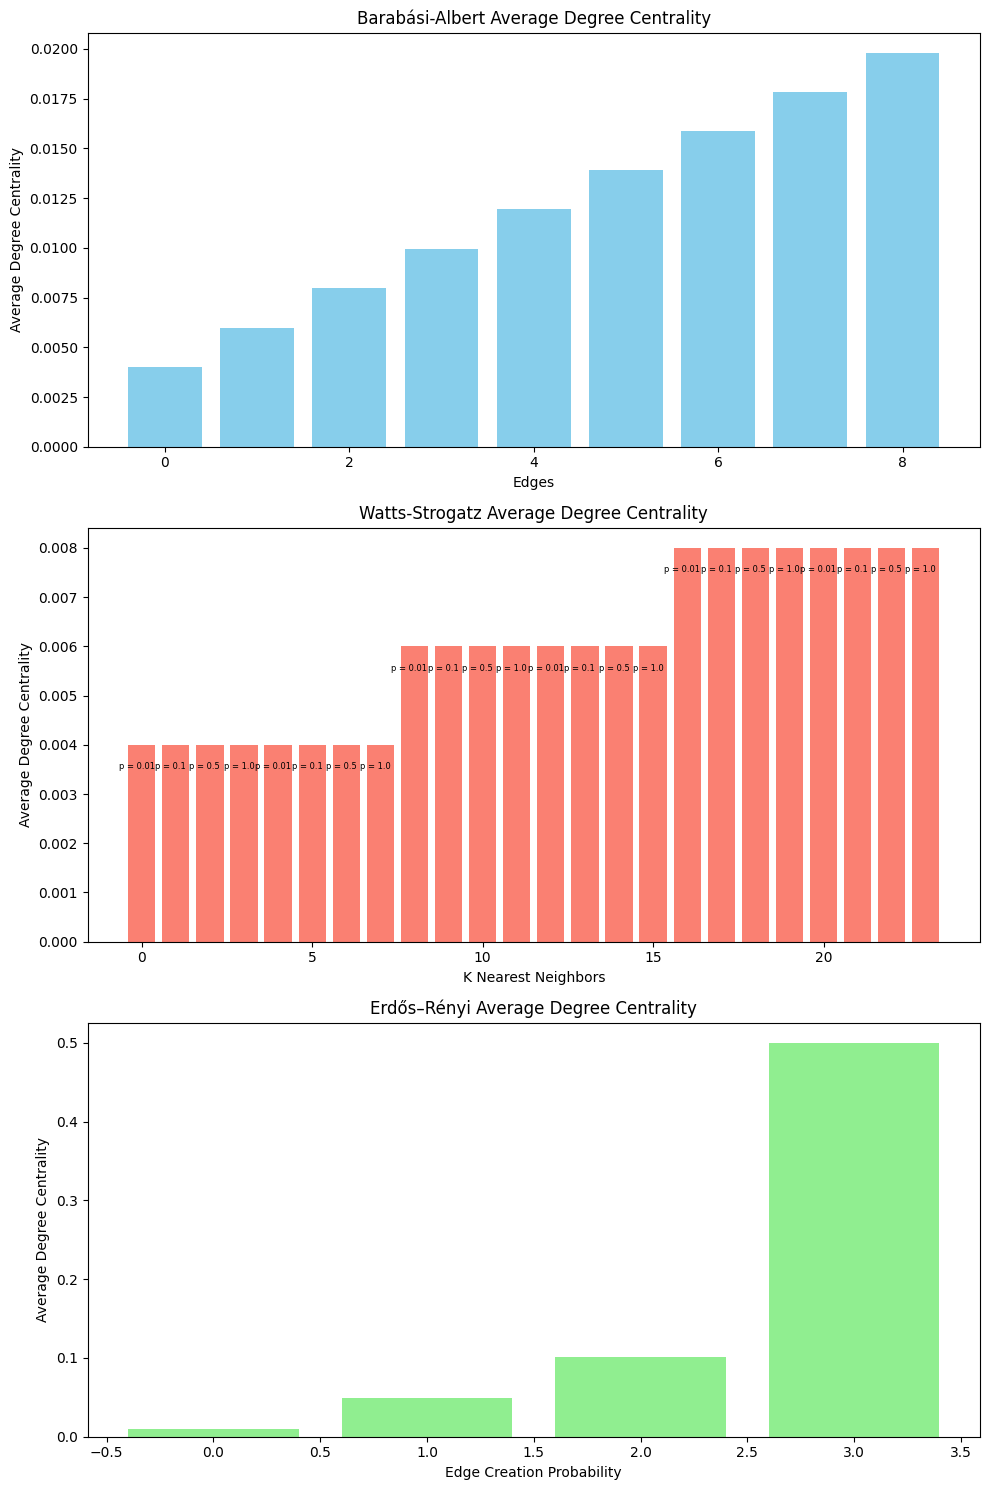

In [21]:
ba_avg_degree_centralities = []
ws_avg_degree_centralities = []
er_avg_degree_centralities = []

for edge in ba_num_of_edges:
    ba_graph = graph.barabasi_albert(num_of_edges=edge)
    avg_degree_centrality = sum(nx.degree_centrality(ba_graph).values()) / N
    ba_avg_degree_centralities.append(avg_degree_centrality)

for k in ws_k_nearest_neighbors:
    for p in ws_rewiring_probabilities:
        ws_graph = graph.watts_strogatz(k_nearest_neighbors=k, rewiring_probability=p)
        avg_degree_centrality = sum(nx.degree_centrality(ws_graph).values()) / N
        ws_avg_degree_centralities.append(avg_degree_centrality)

for p in er_creation_probabilities:
    er_graph = graph.erdos_renyi(edge_creation_probability=p)
    avg_degree_centrality = sum(nx.degree_centrality(er_graph).values()) / N
    er_avg_degree_centralities.append(avg_degree_centrality)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

axes[0].bar(range(len(ba_avg_degree_centralities)), ba_avg_degree_centralities, color='skyblue')
axes[0].set_title('Barabási-Albert Average Degree Centrality')
axes[0].set_xlabel('Edges')
axes[0].set_ylabel('Average Degree Centrality')

bars = axes[1].bar(range(len(ws_avg_degree_centralities)), ws_avg_degree_centralities, color='salmon')
axes[1].set_title('Watts-Strogatz Average Degree Centrality')
axes[1].set_xlabel('K Nearest Neighbors')
axes[1].set_ylabel('Average Degree Centrality')

# Loop to label each bar in the WS plot with rewiring probability
for idx, bar in enumerate(bars):
    rewiring_prob = ws_rewiring_probabilities[idx % len(ws_rewiring_probabilities)]
    axes[1].text(bar.get_x() + bar.get_width() / 2 - 0.15, 
                 bar.get_height() - 0.0005, 
                 f'p = {rewiring_prob}', 
                 ha='center', 
                 color='black',
                 rotation=45,
                 fontsize=6)

axes[2].bar(range(len(er_avg_degree_centralities)), er_avg_degree_centralities, color='lightgreen')
axes[2].set_title('Erdős–Rényi Average Degree Centrality')
axes[2].set_xlabel('Edge Creation Probability')
axes[2].set_ylabel('Average Degree Centrality')

plt.tight_layout()
plt.show()
